# QUBO's hyper parameter search

This notebook is a simple example of how to use `MINTO` to explore the hyperparameter space of a QUBO model.
For this example, we will handle the Traveling Salesman Problem with quadratic assignment formulation. For more details about the Traveling Salesman Problem, please refer to other resources.

In [1]:
import minto
import matplotlib.pyplot as plt
import jijmodeling as jm

In [2]:
import minto.problems.tsp

tsp = minto.problems.tsp.QuadTSP()
tsp_problem = tsp.problem()

n = 8
tsp_data = tsp.data(n=n)

tsp_problem

In [3]:
interpreter = jm.Interpreter(tsp_data)
instance = interpreter.eval_problem(tsp_problem)

In [4]:
parametric_qubo = instance.uniform_penalty_method()

$$
E(x; A) = \sum_{i=0}^{n-1} \sum_{j=0}^{n-1} d_{ij} \sum_{t=0}^{n-1} x_{it} x_{j, (t+1)\mod n} 
+ A \left[
\sum_i \left(\sum_{t} x_{i, t} - 1\right)^2 + \sum_t \left(\sum_{i} x_{i, t} - 1\right)^2
\right]
$$

In [5]:
import ommx_openjij_adapter as oj_ad

A = parametric_qubo.parameters[0]

parameter_values = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

experiment = minto.Experiment(auto_saving=False)
for param in parameter_values:
    with experiment.run():
        qubo = parametric_qubo.with_parameters({A.id: param})
        samples = oj_ad.sample_qubo_sa(qubo, num_reads=20)
        ox_sampleset = qubo.evaluate_samples(samples)
        experiment.log_sampleset(ox_sampleset)
        experiment.log_parameter("A", param)

In [6]:
table = experiment.get_run_table()
table

sampleset_0                                                   \
       num_samples  obj_mean   obj_std   obj_min   obj_max feasible   
run_id                                                                
0               20  2.353298  0.128415  2.197453  2.562081       20   
1               20  2.621065  0.123054  2.403020  2.828407       20   
2               20  2.815103  0.170415  2.470182  3.086925       20   
3               20  2.902571  0.196432  2.470182  3.437990       20   
4               20  2.949916  0.233024  2.470182  3.382462       20   
5               20  2.949862  0.251585  2.567745  3.326603       20   
6               20  2.975748  0.323970  2.470182  3.931625       20   

                               parameter metadata               
       feasible_unrelaxed name         A   run_id elapsed_time  
run_id                                                          
0                       0    0       0.4        0     0.042719  
1                       5    0       0.5        1     0.037797  
2                      17    0       0.6        2     0.045210  
3                      20    0       0.7        3     0.029640  
4                      20    0       0.8        4     0.031473  
5                      20    0       0.9        5     0.027570  
6                      20    0       1.0        6     0.029543

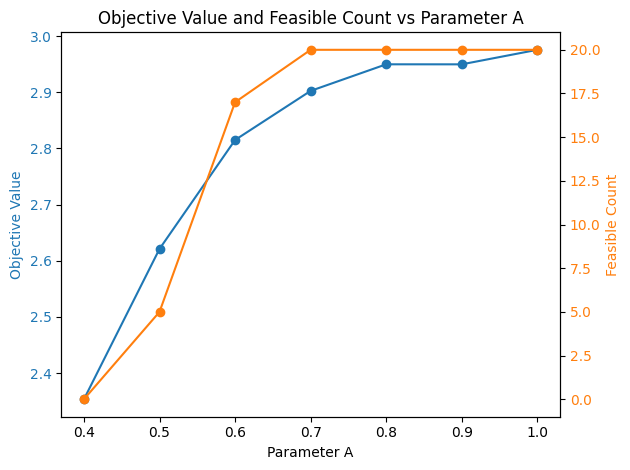

In [7]:
fig, ax1 = plt.subplots()

# First y-axis for objective value
ax1.set_xlabel("Parameter A")
ax1.set_ylabel("Objective Value", color="tab:blue")
ax1.plot(table["parameter"]["A"], table["sampleset_0"]["obj_mean"], "-o", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Second y-axis for feasible count
ax2 = ax1.twinx()
ax2.set_ylabel("Feasible Count", color="tab:orange")
ax2.plot(table["parameter"]["A"], table["sampleset_0"]["feasible"], "-o", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

plt.title("Objective Value and Feasible Count vs Parameter A")
fig.tight_layout()